In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data from CSV files
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Encoding 'Region' column using LabelEncoder
le = LabelEncoder()
customers['Region_encoded'] = le.fit_transform(customers['Region'])

In [4]:
# Feature 1: Days since signup
customers['Days_since_signup'] = (pd.to_datetime('today') - pd.to_datetime(customers['SignupDate'])).dt.days

In [5]:
# Merge transactions with products to get the Price and Category information
merged_data = pd.merge(transactions, products[['ProductID', 'Price', 'Category']], on='ProductID', how='left')

# Aggregate transaction data for each customer
customer_transactions = merged_data.groupby('CustomerID').agg(
    total_purchases=('TransactionID', 'count'),
    total_spending=('TotalValue', 'sum'),
    avg_purchase_amount=('TotalValue', 'mean'),
    freq_purchase_category=('Category', lambda x: x.mode()[0])
).reset_index()

In [6]:
# Merge the customer profile features with transaction features
customer_profiles = customers[['CustomerID', 'Region_encoded', 'Days_since_signup']].merge(customer_transactions, on='CustomerID')

# Create the feature matrix for clustering
features = customer_profiles[['Region_encoded', 'Days_since_signup', 'total_purchases', 'total_spending', 'avg_purchase_amount']]

In [7]:
# Standardizing the features (important for KMeans clustering)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Number of clusters between 2 and 10 (let's try KMeans with 3 clusters for now)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(features_scaled)

In [8]:
# Calculate the Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(features_scaled, customer_profiles['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

Davies-Bouldin Index: 1.6542354982672194


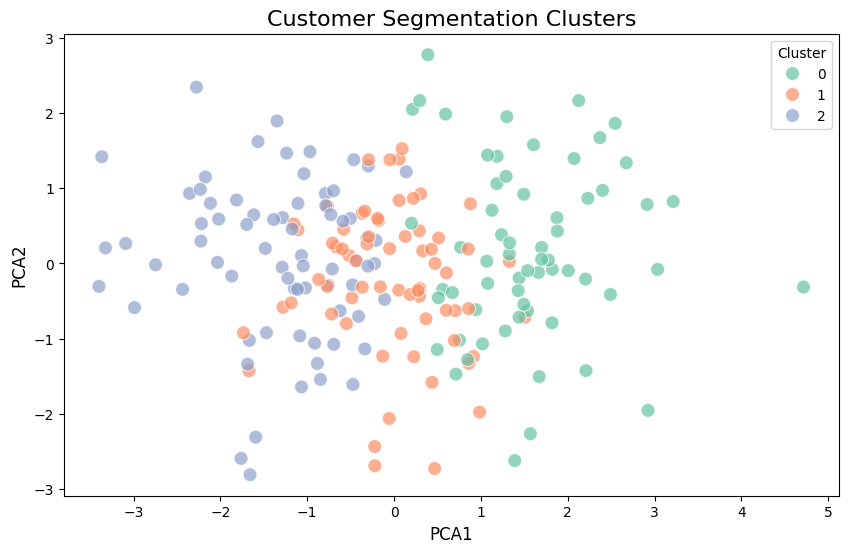

In [9]:
# Add the PCA components to the dataframe
customer_profiles['PCA1'] = principal_components[:, 0]
customer_profiles['PCA2'] = principal_components[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=customer_profiles, s=100, alpha=0.7)
plt.title('Customer Segmentation Clusters', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [10]:
# Save clustering results to CSV
customer_profiles[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customer_profiles['Cluster'] = kmeans.fit_predict(features_scaled)
    db_index = davies_bouldin_score(features_scaled, customer_profiles['Cluster'])
    print(f'Number of clusters: {n_clusters}, Davies-Bouldin Index: {db_index}')

Number of clusters: 2, Davies-Bouldin Index: 1.6189126584772529
Number of clusters: 3, Davies-Bouldin Index: 1.6542354982672194
Number of clusters: 4, Davies-Bouldin Index: 1.4982529463512382
Number of clusters: 5, Davies-Bouldin Index: 1.3061979535335453
Number of clusters: 6, Davies-Bouldin Index: 1.2872054390407095
Number of clusters: 7, Davies-Bouldin Index: 1.3110248331192875
Number of clusters: 8, Davies-Bouldin Index: 1.3376061816460276
Number of clusters: 9, Davies-Bouldin Index: 1.3112244556527441
Number of clusters: 10, Davies-Bouldin Index: 1.2835162404824176
